# Forecast Police Service Calls

***

## Libraries

In [63]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
#import plotly.express as px
#!pip install --disable-pip-version-check -q seaborn==0.11.0
#import seaborn as sns
import datetime
#%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

np.random.seed(1)

***

## Variables - Setup

In [64]:
prefix = "Forecasting/Calls"

db_name = "sdpd"
bucket = 'sdpd-bucket' 
region = boto3.Session().region_name
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

sagemaker_session = sagemaker.Session()
role = get_execution_role()
#bucket = sagemaker_session.default_bucket()
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

s3 = boto3.client("s3")
encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"

s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

Data_length = 1000
prediction_length = 48
context_length = 480


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


***

## Functions

In [65]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [127]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding=encoding,
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

***

## Retrive Data

In [66]:
Stops_Hourly = """SELECT * FROM {}.{}
    order by date_time desc
     LIMIT 1000
     """.format(
    db_name, 'calls_hour'
)

print(Stops_Hourly)

SELECT * FROM sdpd.calls_hour
    order by date_time desc
     LIMIT 1000
     


In [67]:
calls = pd.read_sql(Stops_Hourly, conn)
calls['count'] = calls['count'].astype(int)
calls = calls.sort_values(by='date_time', ascending=True)
calls['timestamp'] = pd.to_datetime(calls.date_time).dt.tz_localize(None)
#calls['date_time'] = calls['date_time'].isoformat()
calls.head(5)

,date_time,count,year,hour,timestamp
999,2023-02-17 08:00:00+00:00,74,2023,8,2023-02-17 08:00:00
998,2023-02-17 09:00:00+00:00,68,2023,9,2023-02-17 09:00:00
997,2023-02-17 10:00:00+00:00,57,2023,10,2023-02-17 10:00:00
996,2023-02-17 11:00:00+00:00,76,2023,11,2023-02-17 11:00:00
995,2023-02-17 12:00:00+00:00,93,2023,12,2023-02-17 12:00:00


In [68]:
call_data= calls['count'].values

In [69]:
#last_row = calls.iloc[-1:]
first_row = calls.iloc[:1]
#first_date = last_row['timestamp']
first_date = first_row['timestamp']
first_date =pd.to_datetime(first_date)
#first_date = first_row['timestamp']
#first_timestamp = first_date.iloc[0].to_pydatetime()
data_length = calls.shape[0]
freq='H'

In [70]:
print(first_date[Data_length-1])

2023-02-17 08:00:00


In [71]:
time_series_calls =[]
index = pd.date_range(start=first_date[Data_length-1], freq=freq, periods=data_length)
time_series_calls.append(pd.Series(data=call_data , index=index))

In [72]:
time_series_calls

[2023-02-17 08:00:00    74
 2023-02-17 09:00:00    68
 2023-02-17 10:00:00    57
 2023-02-17 11:00:00    76
 2023-02-17 12:00:00    93
                        ..
 2023-03-30 19:00:00    49
 2023-03-30 20:00:00    54
 2023-03-30 21:00:00    52
 2023-03-30 22:00:00    52
 2023-03-30 23:00:00    23
 Freq: H, Length: 1000, dtype: int64]

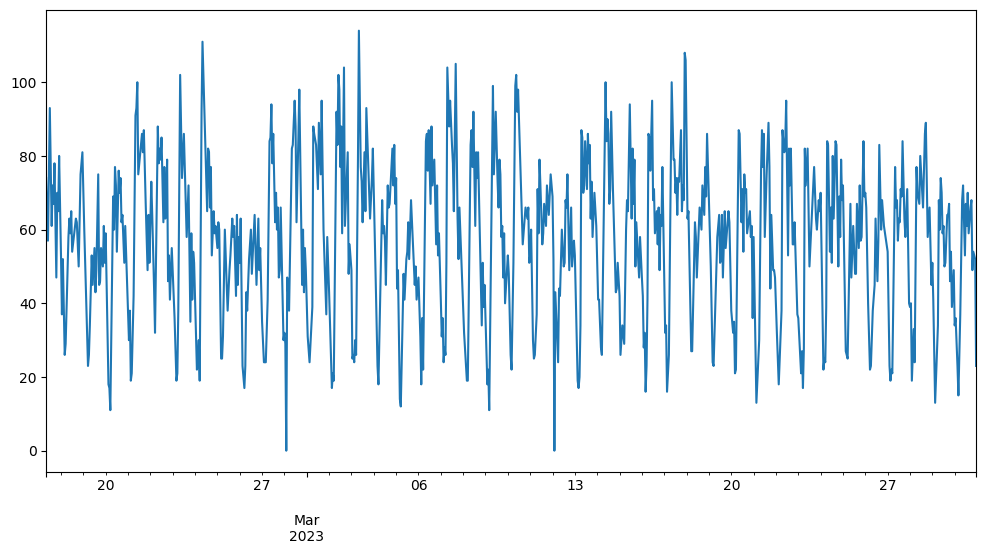

In [128]:
plt.figure(figsize=(12, 6))
plt.style.use('fast')
time_series_calls[0].plot()
plt.show()

***

## Spliy Train and Test

In [74]:
time_series_training = []
for ts in time_series_calls:
    time_series_training.append(ts[:-prediction_length])

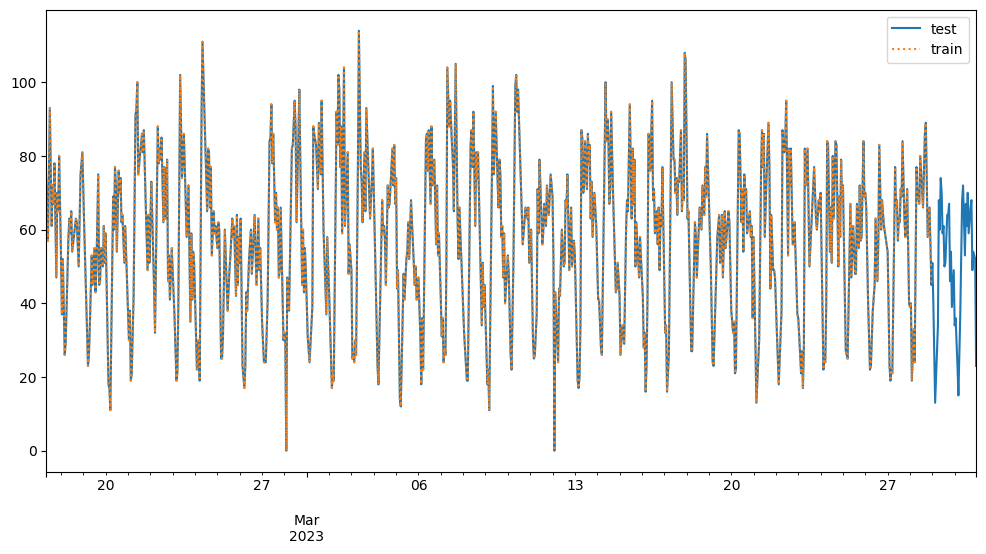

In [75]:
plt.figure(figsize=(12, 6))
time_series_calls[0].plot(label="test")
time_series_training[0].plot(label="train", ls=":")
plt.legend()
plt.show()

***

## Upload Train and Test data as JSON

In [76]:
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in time_series_calls:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
        

s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

***

## Train Model

In [129]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    base_job_name="SDPD-Calls",
    output_path=f"s3://{s3_output_path}",
)

In [130]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "student-T",
    "epochs": "50",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "25",
}

In [131]:
estimator.set_hyperparameters(**hyperparameters)

In [132]:
data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: SDPD-Calls-2023-04-03-03-17-51-438


2023-04-03 03:17:52 Starting - Starting the training job...
2023-04-03 03:18:06 Starting - Preparing the instances for training...
2023-04-03 03:18:51 Downloading - Downloading input data...
2023-04-03 03:19:12 Training - Downloading the training image......
2023-04-03 03:20:17 Training - Training image download completed. Training in progress.Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[04/03/2023 03:20:26 INFO 139755125389120] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'au

***

## Model Metrics

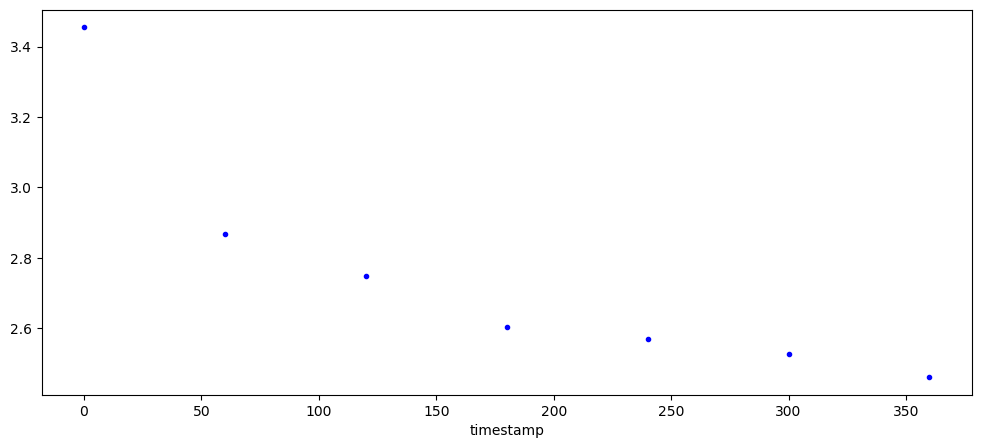

In [140]:
training_job_name = estimator.latest_training_job.name
metric_name = 'train:loss'
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
#plt.pyplot.ylabel(metric_name)
#plt.set_ylabel(metric_name)
plt.show()

In [141]:
training_job_name = estimator.latest_training_job.name
metric_name = 'test:mean_wQuantileLoss'
metrics= TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name])
metrics.dataframe()

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.13758


In [142]:
training_job_name = estimator.latest_training_job.name
metric_name = 'test:RMSE'
metrics= TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name])
metrics.dataframe()

,timestamp,metric_name,value
0,0.0,test:RMSE,10.734515


In [143]:
job_analytics_data = estimator.training_job_analytics
analytics = job_analytics_data.dataframe()
analytics

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.137580
1,0.0,train:loss:batch,3.504078
2,60.0,train:loss:batch,2.843685
3,120.0,train:loss:batch,2.694722
4,180.0,train:loss:batch,2.594581
5,240.0,train:loss:batch,2.621869
6,300.0,train:loss:batch,2.510894
7,360.0,train:loss:batch,2.525181
8,0.0,train:progress,4.000000
9,60.0,train:progress,15.000000


In [144]:
job_name = estimator.latest_training_job.name
analytics = sagemaker_session.sagemaker_client.describe_training_job(
    TrainingJobName=job_name
)['FinalMetricDataList'][6]['Value']
print('Training job RMSE: {}'.format(analytics))

Training job RMSE: 10.734515190124512


In [145]:
client = boto3.client('sagemaker')
description = client.describe_training_job(TrainingJobName=job_name)

In [146]:
# retrieve the RMSE metric from the training job description
rmse = description['FinalMetricDataList'][6]['Value']
print('Training job RMSE: {}'.format(rmse))

Training job RMSE: 10.734515190124512


***

## Endpoint 

In [147]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

INFO:sagemaker:Creating model with name: SDPD-Calls-2023-04-03-03-17-51-438
INFO:sagemaker:Creating endpoint-config with name SDPD-Calls-2023-04-03-03-17-51-438
INFO:sagemaker:Creating endpoint with name SDPD-Calls-2023-04-03-03-17-51-438


-------!

***

## Forecast

In [148]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [149]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series_calls[:5]

In [160]:
actual_data

[2023-02-17 08:00:00    74
 2023-02-17 09:00:00    68
 2023-02-17 10:00:00    57
 2023-02-17 11:00:00    76
 2023-02-17 12:00:00    93
                        ..
 2023-03-30 19:00:00    49
 2023-03-30 20:00:00    54
 2023-03-30 21:00:00    52
 2023-03-30 22:00:00    52
 2023-03-30 23:00:00    23
 Freq: H, Length: 1000, dtype: int64]

In [156]:
-prediction_length - context_length

-528

<Figure size 1200x600 with 0 Axes>

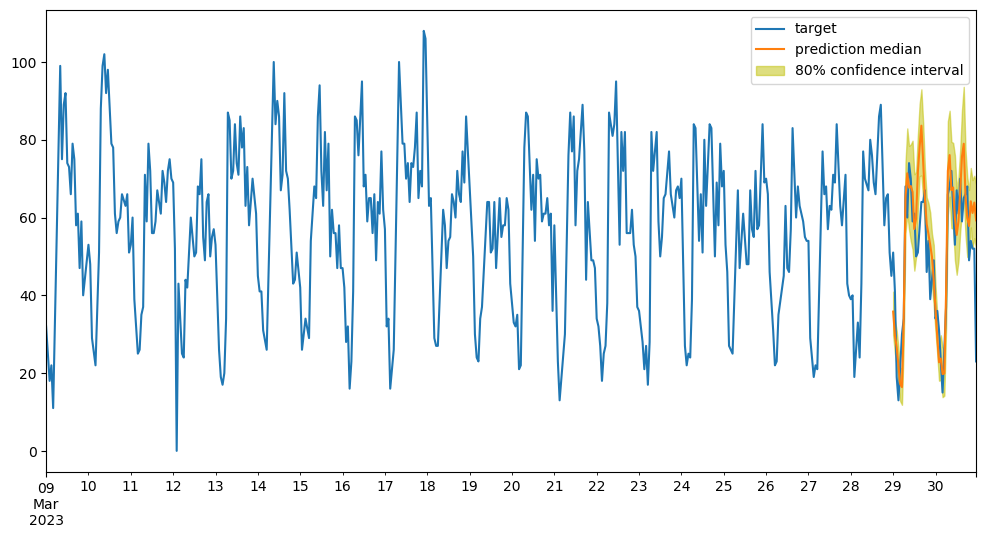

In [159]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    #actual_data[-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [161]:
sagemaker_session.delete_endpoint(endpoint_name)